## To do

See if there are any other risks to consider
get into .py report generator


In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [173]:
# Load data
portfolio = pd.read_csv('submission_folder/positions.csv')
fx_rates = pd.read_csv('submission_folder/fx.csv') 
fx_rates.drop(columns=['Unnamed: 2'], inplace=True)  

portfolio.head()
fx_rates

,currency,to_USD
0,AUD,0.774395
1,BRL,0.304710
2,CAD,0.747211
3,CHF,1.046150
4,CNY,0.158037
5,EUR,1.107643
6,GBP,1.344329
7,HKD,0.130361
8,JPY,0.009876
9,USD,1.000000


# Data Cleaning

In [174]:
# Data cleaning
# rows with any missing values
display(portfolio[portfolio.isnull().any(axis=1)])

# duplicates
display(portfolio[portfolio.duplicated(subset=['stock_id'], keep=False)])

#make sure numeric columns are properly typed
numeric_cols = ['posn_shares', 'cost_basis_local', 'market_price_local', 
                'beta', 'avg_daily_volume']
portfolio[numeric_cols] = portfolio[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check for scientific notation issues (your ADV has "1.36E+08")
# This should parse fine, but verify

# Side should be 'LONG' or 'SHORT' only
assert portfolio['side'].isin(['LONG', 'SHORT']).all()


,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local
2296,2297,equity_2297,MOM,AUS,NaN,Industrials,Transportation,Marine,0.589532,36086448,LONG,3864,135.73,137.41
2305,2306,equity_2306,ONW,ITA,NaN,Consumer Discretionary,Media,Movies & Entertainment,1.310975,81798,SHORT,-3242,158.89,168.70


,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local


In [175]:
# Impute missing currency values
portfolio.loc[portfolio['stock_id'] == 2297, 'currency'] = 'AUD'
portfolio.loc[portfolio['stock_id'] == 2306, 'currency'] = 'EUR'

# Verify
portfolio[portfolio['stock_id'].isin([2297, 2306])]


,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local
2296,2297,equity_2297,MOM,AUS,AUD,Industrials,Transportation,Marine,0.589532,36086448,LONG,3864,135.73,137.41
2305,2306,equity_2306,ONW,ITA,EUR,Consumer Discretionary,Media,Movies & Entertainment,1.310975,81798,SHORT,-3242,158.89,168.70


## Conversion to USD

In [176]:
# Convert all positions to a common currency (USD)
# Calculate position values in local, then convert
portfolio['position_value_local'] = portfolio['posn_shares'] * portfolio['market_price_local']
portfolio['cost_value_local'] = portfolio['posn_shares'] * portfolio['cost_basis_local']
portfolio['unrealized_pnl_local'] = portfolio['position_value_local'] - portfolio['cost_value_local']

# Merge with FX rates
portfolio = portfolio.merge(fx_rates, on='currency', how='left')

# # convert to USD
portfolio['position_value_usd'] = portfolio['position_value_local'] * portfolio['to_USD']
portfolio['cost_value_usd'] = portfolio['cost_value_local'] * portfolio['to_USD']
portfolio['unrealized_pnl_usd'] = portfolio['unrealized_pnl_local'] * portfolio['to_USD']

portfolio.head()

,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local,position_value_local,cost_value_local,unrealized_pnl_local,to_USD,position_value_usd,cost_value_usd,unrealized_pnl_usd
0,1,equity_1,AGI,DEU,EUR,Information Technology,Software & Services,Systems Software,1.735624,10043,SHORT,-4810,145.19,147.06,-707358.60,-698363.90,-8994.70,1.107643,-7.835008e+05,-7.735379e+05,-9962.916501
1,2,equity_2,PWH,RUS,USD,Consumer Staples,Food Beverage & Tobacco,Meat Poultry & Fish,0.675354,640830,LONG,38342,112.48,100.28,3844935.76,4312708.16,-467772.40,1.000000,3.844936e+06,4.312708e+06,-467772.400000
2,3,equity_3,NDE,DEU,USD,Industrials,Capital Goods,Heavy Electrical Equipment,0.699394,36094,SHORT,-19881,43.36,41.56,-826254.36,-862040.16,35785.80,1.000000,-8.262544e+05,-8.620402e+05,35785.800000
3,4,equity_4,ABB,USA,USD,Financials,Insurance,Reinsurance,2.215079,135786553,SHORT,-100194,24.79,26.38,-2643117.72,-2483809.26,-159308.46,1.000000,-2.643118e+06,-2.483809e+06,-159308.460000
4,5,equity_5,WRF,RUS,USD,Utilities,Utilities,Electric Utilities,1.259133,26094,LONG,3963,149.90,149.53,592587.39,594053.70,-1466.31,1.000000,5.925874e+05,5.940537e+05,-1466.310000


# Analysis -------------------------------------

In [183]:
portfolio[portfolio['stock_id'] == 2667]

,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local,position_value_local,cost_value_local,unrealized_pnl_local,to_USD,position_value_usd,cost_value_usd,unrealized_pnl_usd,position_weight,days_to_unwind
2666,2667,equity_2667,SLH,AUS,AUD,Information Technology,Technology Hardware & Equipment,Technology Distributors,2.242258,0,SHORT,-1,63.93,61.41,-61.41,-63.93,2.52,0.774395,-47.555585,-49.50706,1.951475,-1.437060e-08,inf


In [178]:
# 1. PORTFOLIO SUMMARY
total_gmv = portfolio['position_value_usd'].abs().sum()  # Gross Market Value
total_nmv = portfolio['position_value_usd'].sum()        # Net Market Valuex
net_gross_ratio = total_nmv / total_gmv                  # Should be ~0 for market neutral

long_mv = portfolio[portfolio['side'] == 'LONG']['position_value_usd'].sum()
short_mv = portfolio[portfolio['side'] == 'SHORT']['position_value_usd'].sum()

total_pnl = portfolio['unrealized_pnl_usd'].sum()
num_positions = len(portfolio)
num_long = len(portfolio[portfolio['side'] == 'LONG'])
num_short = len(portfolio[portfolio['side'] == 'SHORT'])

# 2. PORTFOLIO BETA (most important for factor neutrality!)
portfolio['position_weight'] = portfolio['position_value_usd'] / total_gmv
portfolio_beta = (portfolio['beta'] * portfolio['position_weight'].abs()).sum()

# net beta
portfolio_beta_net = (portfolio['beta'] * portfolio['position_weight']).sum()

In [179]:
# 3. SECTOR EXPOSURE
sector_exposure = portfolio.groupby('sector').agg({
    'position_value_usd': ['sum', lambda x: x.abs().sum()],  # net, gross
    'unrealized_pnl_usd': 'sum',
    'stock_id': 'count'
}).round(4)

sector_exposure.columns = ['Net_Exposure_USD', 'Gross_Exposure_USD', 'PnL_USD', 'Num_Positions']
sector_exposure['Net_Pct_GMV'] = (sector_exposure['Net_Exposure_USD'] / total_gmv * 100).round(4)
sector_exposure['Gross_Pct_GMV'] = (sector_exposure['Gross_Exposure_USD'] / total_gmv * 100).round(4)

# 4. COUNTRY EXPOSURE
country_exposure = portfolio.groupby('country').agg({
    'position_value_usd': ['sum', lambda x: x.abs().sum()],
    'unrealized_pnl_usd': 'sum',
    'stock_id': 'count'
}).round(4)
country_exposure.columns = ['Net_Exposure_USD', 'Gross_Exposure_USD', 'PnL_USD', 'Num_Positions']
country_exposure['Net_Pct_GMV'] = (country_exposure['Net_Exposure_USD'] / total_gmv * 100).round(4)
country_exposure['Gross_Pct_GMV'] = (country_exposure['Gross_Exposure_USD'] / total_gmv * 100).round(4)

# 5. CURRENCY EXPOSURE (pre-hedge)
currency_exposure = portfolio.groupby('currency').agg({
    'position_value_usd': ['sum', lambda x: x.abs().sum()],
    'stock_id': 'count'
}).round(4)
currency_exposure.columns = ['Net_Exposure_USD', 'Gross_Exposure_USD', 'Num_Positions']
currency_exposure['Net_Pct_GMV'] = (currency_exposure['Net_Exposure_USD'] / total_gmv * 100).round(4)
currency_exposure['Gross_Pct_GMV'] = (currency_exposure['Gross_Exposure_USD'] / total_gmv * 100).round(4)

In [180]:
# 6. CONCENTRATION RISK
concentration_threshold = .03  # 5% of GMV
concentrated_positions = portfolio[portfolio['position_weight'] > concentration_threshold]

# 7. LIQUIDITY RISK
# Position size relative to average daily volume
portfolio['days_to_unwind'] = (
    portfolio['posn_shares'].abs() / portfolio['avg_daily_volume']
).round(4)

liquidity_threshold = 3  # Flag if takes >5 days to unwind
illiquid_positions = portfolio[portfolio['days_to_unwind'] > liquidity_threshold]

# 8. BETA OUTLIERS
beta_threshold = 4.0
high_beta = portfolio[portfolio['beta'].abs() > beta_threshold]

# 9. LARGEST P&L CONTRIBUTORS
top_winners = portfolio.nlargest(10, 'unrealized_pnl_usd')[
    ['name', 'ticker', 'sector', 'side', 'unrealized_pnl_usd', 'position_value_usd']
]
top_losers = portfolio.nsmallest(10, 'unrealized_pnl_usd')[
    ['name', 'ticker', 'sector', 'side', 'unrealized_pnl_usd', 'position_value_usd']
]

# 10. LONG VS SHORT IMBALANCE
long_short_ratio = abs(long_mv / short_mv) if short_mv != 0 else float('inf')

In [181]:
def generate_daily_risk_report(portfolio):
    """
    Generate formatted daily risk report for trading staff
    """
    
    print("=" * 80)
    print("DAILY RISK REPORT - FACTOR NEUTRAL GLOBAL EQUITIES")
    print(f"Report Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
    print("=" * 80)
    
    # EXECUTIVE SUMMARY
    print("\n>>> EXECUTIVE SUMMARY")
    # print(f"Portfolio Beta: {portfolio_beta:.3f}")
    print(f"Portfolio Net Beta: {portfolio_beta_net:.3f}")
    print(f"Net/Gross Ratio: {net_gross_ratio:.2%}")
    print(f"Long/Short Ratio: {long_short_ratio:.2f}x")
    
    # Red flags
    print("\n>>> KEY RISKS IDENTIFIED")
    if abs(portfolio_beta_net) > 0.1:
        print(f"⚠️  Portfolio net beta {portfolio_beta:.3f} exceeds neutral threshold (±0.1)")
    if abs(net_gross_ratio) > 0.05:
        print(f"⚠️  Net/Gross ratio {net_gross_ratio:.2%} indicates directional bias")
    if len(concentrated_positions) > 0:
        print(f"⚠️  {len(concentrated_positions)} positions exceed {concentration_threshold:.2%} concentration threshold")
    if len(illiquid_positions) > 0:
        print(f"⚠️  {len(illiquid_positions)} positions would take >{liquidity_threshold} days to unwind")
    if len(high_beta) > 0:
        print(f"⚠️  {len(high_beta)} positions have extreme beta (|β| > {beta_threshold})")
    
    # PORTFOLIO OVERVIEW
    print("\n" + "=" * 80)
    print("PORTFOLIO OVERVIEW")
    print("=" * 80)
    print(f"Gross Market Value:    ${total_gmv:,.0f}")
    print(f"Net Market Value:      ${total_nmv:,.0f}")
    print(f"Long Market Value:     ${long_mv:,.0f}")
    print(f"Short Market Value:    ${short_mv:,.0f}")
    print(f"Unrealized P&L:        ${total_pnl:,.0f}")
    print(f"Total Positions:       {num_positions} ({num_long} long, {num_short} short)")
    
    # EXPOSURE ANALYSIS
    print("\n" + "=" * 80)
    print("SECTOR EXPOSURE")
    print("=" * 80)
    print(sector_exposure.sort_values('Gross_Pct_GMV', ascending=False).to_string())
    
    print("\n" + "=" * 80)
    print("COUNTRY EXPOSURE")
    print("=" * 80)
    print(country_exposure.sort_values('Gross_Pct_GMV', ascending=False).to_string())
    
    print("\n" + "=" * 80)
    print("CURRENCY EXPOSURE")
    print("=" * 80)
    print(currency_exposure.sort_values('Gross_Pct_GMV', ascending=False).to_string())
    
    # RISK FLAGS
    print("\n" + "=" * 80)
    print("RISK FLAGS - CONCENTRATED POSITIONS (>5% GMV)")
    print("=" * 80)
    if len(concentrated_positions) > 0:
        print(concentrated_positions[['name', 'ticker', 'sector', 'pct_of_gmv', 
                                      'position_value_usd']].to_string(index=False))
    else:
        print("No concentrated positions.")
    
    print("\n" + "=" * 80)
    print("RISK FLAGS - ILLIQUID POSITIONS (>5 days to unwind)")
    print("=" * 80)
    if len(illiquid_positions) > 0:
        print(illiquid_positions[['name', 'ticker', 'days_to_unwind', 
                                  'avg_daily_volume', 'posn_shares']].to_string(index=False))
    else:
        print("No illiquid positions.")
    
    print("\n" + "=" * 80)
    print(f"RISK FLAGS - EXTREME BETA (|β| > {beta_threshold})")
    print("=" * 80)
    if len(high_beta) > 0:
        print(high_beta[['name', 'ticker', 'beta', 'position_value_usd', 
                        'sector']].to_string(index=False))
    else:
        print("No extreme beta positions.")
    
    # P&L ATTRIBUTION
    print("\n" + "=" * 80)
    print("TOP 5 P&L CONTRIBUTORS (Winners)")
    print("=" * 80)
    print(top_winners.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("TOP 5 P&L DETRACTORS (Losers)")
    print("=" * 80)
    print(top_losers.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("END OF REPORT")
    print("=" * 80)

# Generate the report
generate_daily_risk_report(portfolio)

DAILY RISK REPORT - FACTOR NEUTRAL GLOBAL EQUITIES
Report Date: 2025-10-22 11:42

>>> EXECUTIVE SUMMARY
Portfolio Net Beta: -0.034
Net/Gross Ratio: -2.11%
Long/Short Ratio: 0.96x

>>> KEY RISKS IDENTIFIED
⚠️  1 positions would take >3 days to unwind
⚠️  20 positions have extreme beta (|β| > 4.0)

PORTFOLIO OVERVIEW
Gross Market Value:    $3,309,227,080
Net Market Value:      $-69,776,056
Long Market Value:     $1,619,725,512
Short Market Value:    $-1,689,501,568
Unrealized P&L:        $29,594,257
Total Positions:       3000 (1468 long, 1532 short)

SECTOR EXPOSURE
                            Net_Exposure_USD  Gross_Exposure_USD       PnL_USD  Num_Positions  Net_Pct_GMV  Gross_Pct_GMV
sector                                                                                                                   
Financials                     -1.802249e+06        7.715557e+08  7.757475e+06            538      -0.0545        23.3153
Consumer Discretionary         -1.820910e+07        6.779567e+

# Visualizations

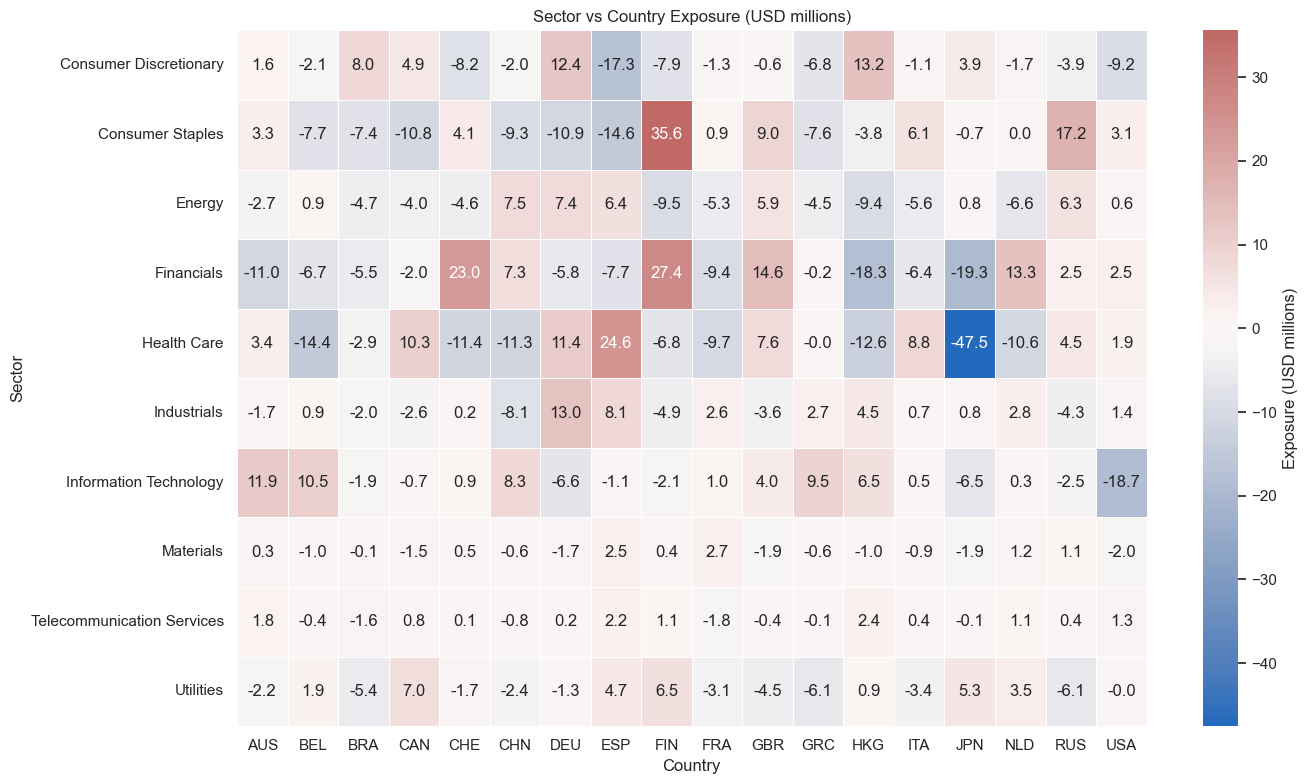

In [144]:
sector_country = portfolio.groupby(['sector', 'country'])['position_value_usd'].sum().unstack(fill_value=0)
sector_country
# Heatmap of sector vs country exposures (USD)
plt.figure(figsize=(14, 8))
# convert to billions for readability (optional)
heat_df = sector_country.copy()
# If you prefer raw USD values, comment out the next line
heat_df = heat_df / 1e6  # show values in millions
sns.set(style="white")
ax = sns.heatmap(heat_df.fillna(0), cmap="vlag", center=0, annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Exposure (USD millions)'} )
ax.set_title('Sector vs Country Exposure (USD millions)')
ax.set_xlabel('Country')
ax.set_ylabel('Sector')
plt.tight_layout()
plt.show()

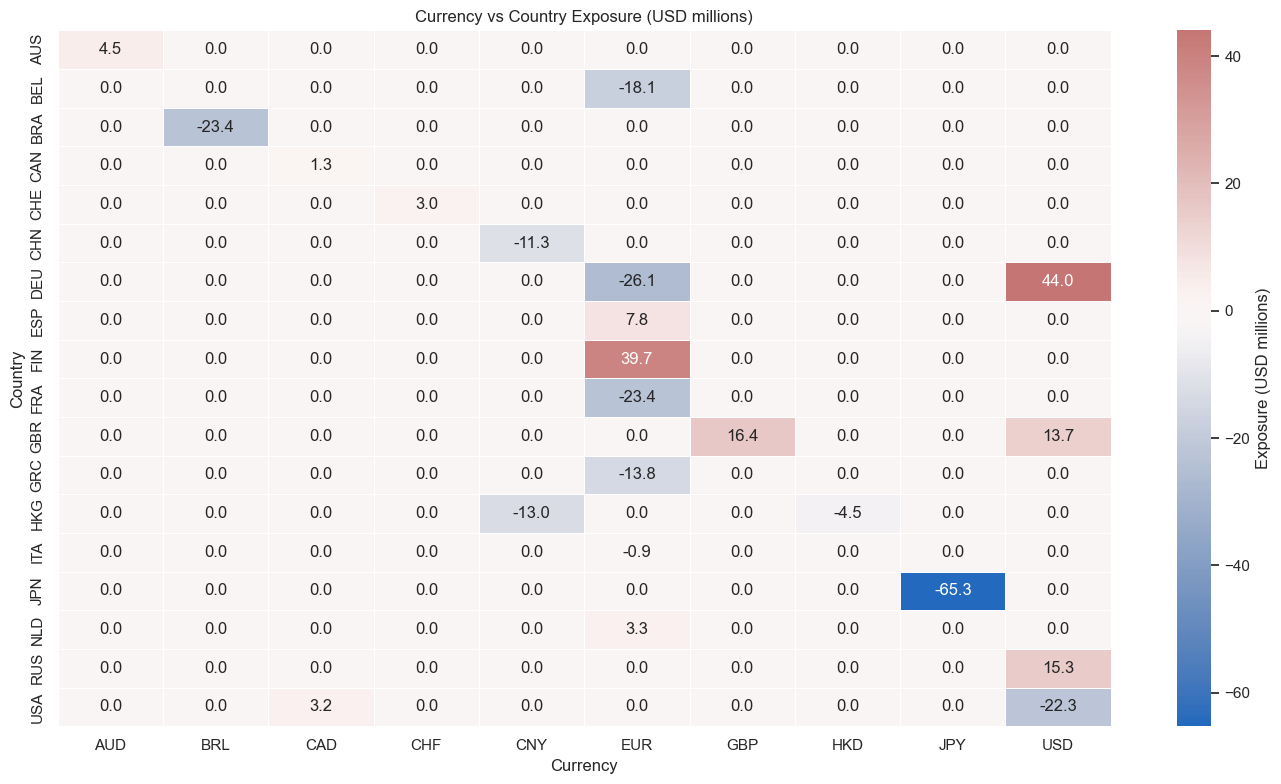

In [136]:
currency_country = portfolio.groupby(['country', 'currency'])['position_value_usd'].sum().unstack(fill_value=0)
# Heatmap of sector vs country exposures (USD)
plt.figure(figsize=(14, 8))
# convert to billions for readability (optional)
heat_df = currency_country.copy()
# If you prefer raw USD values, comment out the next line
heat_df = heat_df / 1e6  # show values in millions
sns.set(style="white")
ax = sns.heatmap(heat_df.fillna(0), cmap="vlag", center=0, annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Exposure (USD millions)'} )
ax.set_title('Currency vs Country Exposure (USD millions)')
ax.set_xlabel('Currency')
ax.set_ylabel('Country')
plt.tight_layout()
plt.show()

In [137]:
sector_pnl = portfolio.groupby('sector')['unrealized_pnl_usd'].sum().sort_values(ascending=False)
sector_pnl

sector
Industrials                   2.616941e+06
Health Care                   2.172068e+06
Energy                        1.122201e+06
Telecommunication Services    2.903235e+05
Materials                     1.048880e+05
Consumer Staples             -6.466800e+04
Information Technology       -1.304992e+05
Financials                   -5.537616e+05
Utilities                    -1.228323e+06
Consumer Discretionary       -1.576890e+06
Name: unrealized_pnl_usd, dtype: float64

In [138]:
# Simulate market shock
market_shock = 0.02  # 2% up
portfolio['shock_pnl'] = (portfolio['beta'] * market_shock * 
                          portfolio['position_value_usd'])

# If portfolio beta is truly neutral, this should ~= 0
simulated_loss = portfolio['shock_pnl'].sum() / total_gmv
print(f"Simulated P&L under 2% market shock: {simulated_loss:.6%}")

# Identify which positions would hurt most
worst_in_shock = portfolio.nsmallest(5, 'shock_pnl')
worst_in_shock

Simulated P&L under 2% market shock: -0.068019%


,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local,position_value_local,cost_value_local,unrealized_pnl_local,to_USD,position_value_usd,cost_value_usd,unrealized_pnl_usd,position_weight,days_to_unwind,shock_pnl
2451,2452,equity_2452,LCO,CHE,CHF,Health Care,Pharmaceuticals & Biotechnology,Life Sciences Tools & Services,4.068492,138539,SHORT,-148785,40.91,41.83,-6223676.55,-6086794.35,136882.20,1.046150,-6.510900e+06,-6.367701e+06,143199.333104,-0.001967,1.0740,-529790.867747
2755,2756,equity_2756,VSU,BEL,EUR,Health Care,Pharmaceuticals & Biotechnology,Life Sciences Tools & Services,1.892090,1878600640,SHORT,-199985,56.74,61.09,-12217083.65,-11347148.90,869934.75,1.107643,-1.353217e+07,-1.256859e+07,963577.137164,-0.004089,0.0001,-512081.561679
2817,2818,equity_2818,RHS,USA,CAD,Consumer Staples,Household & Personal Products,Household Products,3.280343,264262,SHORT,-99096,90.56,84.70,-8393431.20,-8974133.76,-580702.56,0.747211,-6.271666e+06,-6.705574e+06,-433907.497931,-0.001895,0.3750,-411464.391449
1402,1403,equity_1403,HEW,USA,CAD,Financials,Banks,Regional Banks,3.519518,4294021,SHORT,-37666,213.08,200.47,-7550903.02,-8025871.28,-474968.26,0.747211,-5.642120e+06,-5.997021e+06,-354901.637239,-0.001705,0.0088,-397150.897788
2609,2610,equity_2610,AOG,USA,USD,Health Care,Pharmaceuticals & Biotechnology,Biotechnology,1.574179,1583674483,SHORT,-166051,73.83,70.14,-11646817.14,-12259545.33,-612728.19,1.000000,-1.164682e+07,-1.225955e+07,-612728.190000,-0.003519,0.0001,-366683.576042


# Testing

In [151]:
portfolio = pd.read_csv('positions.csv')
fx_rates = pd.read_csv('fx.csv')

# removes unnamed columns if any
fx_rates = fx_rates[[col for col in fx_rates.columns if 'Unnamed' not in col]]

portfolio = portfolio.merge(fx_rates, on='currency', how='left')
    
# there are some missing currency codes, fill based on country
currency_map = {
    'AUS': 'AUD',
    'USA': 'USD',
    'GBR': 'GBP',
    'JPN': 'JPY',
    'CHE': 'CHF',
    'CAN': 'CAD',
    'FRA': 'EUR',
    'GER': 'EUR',
    'ITA': 'EUR',
    'ESP': 'EUR',
    'NLD': 'EUR',
    'BEL': 'EUR',
    'CHN': 'CNY',
    'HKG': 'HKD',
    'BRA': 'BRL'
}

for idx, row in portfolio[portfolio['currency'].isna()].iterrows():
    if row['country'] in currency_map:
        portfolio.at[idx, 'currency'] = currency_map[row['country']]

# Re-merge FX rates for filled currencies
portfolio = portfolio.drop(columns=['to_USD'], errors='ignore')
portfolio = portfolio.merge(fx_rates, on='currency', how='left')

# Calculate position values
portfolio['position_value_local'] = portfolio['posn_shares'] * portfolio['market_price_local']
portfolio['cost_value_local'] = portfolio['posn_shares'] * portfolio['cost_basis_local']
portfolio['unrealized_pnl_local'] = portfolio['position_value_local'] - portfolio['cost_value_local']

# Convert to USD
portfolio['position_value_usd'] = portfolio['position_value_local'] * portfolio['to_USD']
portfolio['cost_value_usd'] = portfolio['cost_value_local'] * portfolio['to_USD']
portfolio['unrealized_pnl_usd'] = portfolio['unrealized_pnl_local'] * portfolio['to_USD']

# Calculate portfolio weights
total_gmv = portfolio['position_value_usd'].abs().sum()
portfolio['position_weight'] = portfolio['position_value_usd'] / total_gmv
portfolio['dollar_weight'] = portfolio['position_value_usd'].abs() / total_gmv

# Calculate days to unwind (assuming we can trade 10% of daily volume)
portfolio['days_to_unwind'] = (portfolio['posn_shares'].abs() / 
                                (portfolio['avg_daily_volume'] * 0.10))

portfolio


,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local,to_USD,position_value_local,cost_value_local,unrealized_pnl_local,position_value_usd,cost_value_usd,unrealized_pnl_usd,position_weight,dollar_weight,days_to_unwind
0,1,equity_1,AGI,DEU,EUR,Information Technology,Software & Services,Systems Software,1.735624,10043,SHORT,-4810,145.19,147.06,1.107643,-707358.60,-698363.90,-8994.70,-7.835008e+05,-7.735379e+05,-9962.916501,-0.000237,0.000237,4.789406
1,2,equity_2,PWH,RUS,USD,Consumer Staples,Food Beverage & Tobacco,Meat Poultry & Fish,0.675354,640830,LONG,38342,112.48,100.28,1.000000,3844935.76,4312708.16,-467772.40,3.844936e+06,4.312708e+06,-467772.400000,0.001162,0.001162,0.598318
2,3,equity_3,NDE,DEU,USD,Industrials,Capital Goods,Heavy Electrical Equipment,0.699394,36094,SHORT,-19881,43.36,41.56,1.000000,-826254.36,-862040.16,35785.80,-8.262544e+05,-8.620402e+05,35785.800000,-0.000250,0.000250,5.508118
3,4,equity_4,ABB,USA,USD,Financials,Insurance,Reinsurance,2.215079,135786553,SHORT,-100194,24.79,26.38,1.000000,-2643117.72,-2483809.26,-159308.46,-2.643118e+06,-2.483809e+06,-159308.460000,-0.000799,0.000799,0.007379
4,5,equity_5,WRF,RUS,USD,Utilities,Utilities,Electric Utilities,1.259133,26094,LONG,3963,149.90,149.53,1.000000,592587.39,594053.70,-1466.31,5.925874e+05,5.940537e+05,-1466.310000,0.000179,0.000179,1.518740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,equity_2996,HSH,CAN,CAD,Information Technology,Technology Hardware & Equipment,Electronic Manufacturing Services,1.723244,3193,SHORT,-232,238.13,249.60,0.747211,-57907.20,-55246.16,-2661.04,-4.326891e+04,-4.128055e+04,-1988.359081,-0.000013,0.000013,0.726589
2996,2997,equity_2997,QLG,BEL,EUR,Utilities,Utilities,Gas Utilities,0.977303,291651784,LONG,77866,11.07,10.13,1.107643,788782.58,861976.62,-73194.04,8.736895e+05,9.547624e+05,-81072.866121,0.000264,0.000264,0.002670
2997,2998,equity_2998,YOV,DEU,USD,Utilities,Utilities,Gas Utilities,1.186587,1955,LONG,3743,141.71,160.19,1.000000,599591.17,530420.53,69170.64,5.995912e+05,5.304205e+05,69170.640000,0.000181,0.000181,19.145780
2998,2999,equity_2999,YFG,HKG,CNY,Consumer Discretionary,Retailing,Internet Retail,0.799109,11685566,LONG,49551,225.50,235.19,0.158037,11653899.69,11173750.50,480149.19,1.841747e+06,1.765866e+06,75881.329377,0.000557,0.000557,0.042404


In [172]:
portfolio

,stock_id,name,ticker,country,currency,sector,industry,sub_industry,beta,avg_daily_volume,side,posn_shares,cost_basis_local,market_price_local,position_value_local,cost_value_local,unrealized_pnl_local,to_USD,position_value_usd,cost_value_usd,unrealized_pnl_usd,position_weight,days_to_unwind
0,1,equity_1,AGI,DEU,EUR,Information Technology,Software & Services,Systems Software,1.735624,10043,SHORT,-4810,145.19,147.06,-707358.60,-698363.90,-8994.70,1.107643,-7.835008e+05,-7.735379e+05,-9962.916501,-0.000237,0.4789
1,2,equity_2,PWH,RUS,USD,Consumer Staples,Food Beverage & Tobacco,Meat Poultry & Fish,0.675354,640830,LONG,38342,112.48,100.28,3844935.76,4312708.16,-467772.40,1.000000,3.844936e+06,4.312708e+06,-467772.400000,0.001162,0.0598
2,3,equity_3,NDE,DEU,USD,Industrials,Capital Goods,Heavy Electrical Equipment,0.699394,36094,SHORT,-19881,43.36,41.56,-826254.36,-862040.16,35785.80,1.000000,-8.262544e+05,-8.620402e+05,35785.800000,-0.000250,0.5508
3,4,equity_4,ABB,USA,USD,Financials,Insurance,Reinsurance,2.215079,135786553,SHORT,-100194,24.79,26.38,-2643117.72,-2483809.26,-159308.46,1.000000,-2.643118e+06,-2.483809e+06,-159308.460000,-0.000799,0.0007
4,5,equity_5,WRF,RUS,USD,Utilities,Utilities,Electric Utilities,1.259133,26094,LONG,3963,149.90,149.53,592587.39,594053.70,-1466.31,1.000000,5.925874e+05,5.940537e+05,-1466.310000,0.000179,0.1519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,equity_2996,HSH,CAN,CAD,Information Technology,Technology Hardware & Equipment,Electronic Manufacturing Services,1.723244,3193,SHORT,-232,238.13,249.60,-57907.20,-55246.16,-2661.04,0.747211,-4.326891e+04,-4.128055e+04,-1988.359081,-0.000013,0.0727
2996,2997,equity_2997,QLG,BEL,EUR,Utilities,Utilities,Gas Utilities,0.977303,291651784,LONG,77866,11.07,10.13,788782.58,861976.62,-73194.04,1.107643,8.736895e+05,9.547624e+05,-81072.866121,0.000264,0.0003
2997,2998,equity_2998,YOV,DEU,USD,Utilities,Utilities,Gas Utilities,1.186587,1955,LONG,3743,141.71,160.19,599591.17,530420.53,69170.64,1.000000,5.995912e+05,5.304205e+05,69170.640000,0.000181,1.9146
2998,2999,equity_2999,YFG,HKG,CNY,Consumer Discretionary,Retailing,Internet Retail,0.799109,11685566,LONG,49551,225.50,235.19,11653899.69,11173750.50,480149.19,0.158037,1.841747e+06,1.765866e+06,75881.329377,0.000557,0.0042
